## Dataset Description 

https://github.com/walkerkq/musiclyrics

Billboard has published a Year-End Hot 100 every December since 1958. The chart measures the performance of singles in the U.S. throughout the year. Using R, I’ve combined the lyrics from 50 years of Billboard Year-End Hot 100 (1965-2015) into one dataset for analysis. You can download that dataset here.

The songs used for analysis were scraped from Wikipedia’s entry for each Billboard Year-End Hot 100 Songs (e.g., 2014). This is the year-end chart, not weekly rankings. Many artists have made the weekly chart but not the final year end chart. The final chart is calculated using an inverse point system based on the weekly Billboard charts (100 points for a week at number one, 1 point for a week at number 100, etc).

I used the xml and RCurl packages to scrape song and artist names from each Wikipedia entry. I then used that list to scrape lyrics from sites that had predictable URL strings (for example, metrolyrics.com uses metrolyrics.com/SONG-NAME-lyrics-ARTIST-NAME.html). If the first site scrape failed, I moved onto the second, and so on. About 78.9% of the lyrics were scraped from metrolyics.com, 15.7% from songlyrics.com, 1.8% from lyricsmode.com. About 3.6% (187/5100) were unavailable.

The dataset features 5100 observations with the features rank (1-100), song, artist, year, lyrics, and source. The artist feature is fairly standardized thanks to Wikipedia, but there is still quite a bit of noise when it comes to artist collaborations (Justin Timberlake featuring Timbaland, for example). If there were any errors in the lyrics that were scraped, such as spelling errors or derivatives like "nite" instead of "night," they haven't been corrected.

Full analysis can be found here.

# Imports and Data Loading

In [12]:
%matplotlib inline

import pandas as pd
import numpy as np
import pickle

from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize

from Levenshtein import distance as levenshtein_distance

import matplotlib.pyplot as plt

### Lyrics Top-100 dataset

In [ ]:
data_file_incomplete = "datasets/billboard_lyrics_1964-2015.csv"
data_file = "datasets/billboard_full.csv"

df_incomplete = pd.read_csv(data_file_incomplete, encoding = "ANSI") # utf-8 encoding doesn't work somehow :(
df = pd.read_csv(data_file, index_col=0, header=0, sep=",") 

df.head()

In [ ]:
len(df.Artist.unique())

## Number of years in Top 100 per Song

In [ ]:
df_count = df.groupby(["Artist", "Song"]).Year.agg(list).to_frame()
df_count["Count"] = df_count.Year.apply(len)
df_count = df_count.sort_values("Count", ascending = False)
df_count.head()

In [ ]:
plt.pie(df_count["Count"].value_counts(), labels = [1, 2], autopct='%1.1f%%')
plt.show()

## Genre

In [ ]:
vc_genre = df.Genre.value_counts()
vc_genre = vc_genre[vc_genre > 70] # Filter very unfrequent

plt.figure(figsize=(10,6))
plt.pie(vc_genre.values, labels = vc_genre.index, autopct='%1.1f%%')
# plt.savefig("images/genre_distribution.png")
plt.show()

## Number of songs in top 100 per artist (if a song is twice, is counted twice)

In [ ]:
df.Artist.value_counts().describe()

In [ ]:
df_songCounts = df.groupby("Artist").Song.count()
df_rndArtist = df_songCounts.to_frame().reset_index().groupby("Song").agg(list)
df_rndArtist["Artist"] = df_rndArtist["Artist"].apply(lambda a : np.random.choice(a, 1)[0])

df_labels = pd.DataFrame(range(1, df_songCounts.max() + 1), columns = ["Song"])
df_labels["Artist"] = ""
df_labels = df_labels.set_index("Song")
df_labels.update(df_rndArtist)

In [ ]:
tmp = df_songCounts.value_counts()
tmp[tmp.index <= 3].sum() / tmp.sum()

In [ ]:
bins = range(1, df_songCounts.max() + 1)
plt.figure(figsize=(12,6))
plt.hist(df_songCounts, bins = bins)
plt.xticks(bins, df_labels["Artist"], rotation='vertical')
plt.yscale("log")
plt.title("Number of times appearing in Top-100 per Artist, with randomly selected artist per bin")
# plt.savefig("images/songs_per_artist.png", bbox_inches='tight')
plt.show()

## Lyrics statistics

In [ ]:
lyrics_lengths = df.Lyrics.apply(lambda s : len(s.split(" ")))

bins = range(1, 1000)
plt.hist(lyrics_lengths, bins = bins)
plt.title("Number of words per song")
plt.savefig("words.png")
plt.show()

In [ ]:
lyrics_lengths.describe()

In [ ]:
lyrics_lengths_unique = df.Lyrics.apply(lambda s : len(set(s.split(" "))))

bins = range(1, 1000)
plt.hist(lyrics_lengths_unique, bins = bins)
plt.title("Number of unique words per song")
plt.savefig("unique_words.png")
plt.show()

In [ ]:
lyrics_lengths_unique.describe()

### Clusterisation of texts

In [ ]:
from nltk import pos_tag, sent_tokenize, wordpunct_tokenize
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) 

def lemmatize(token, pos_tag):
    tag = {
        'N': wn.NOUN,
        'V': wn.VERB,
        'R': wn.ADV,
        'J': wn.ADJ
    }.get(pos_tag[0], wn.NOUN)
    return lemmatizer.lemmatize(token, tag)

def preprocess_lyrics(lyrics):
    tagged_tokens = pos_tag(wordpunct_tokenize(lyrics))
    preprocessed = [lemmatize(token, tag) for (token, tag) in tagged_tokens if not token in stop_words]
    return " ".join(preprocessed)

In [ ]:
preprocessed_lyrics = df.Lyrics.fillna("").apply(preprocess_lyrics)

In [ ]:
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english', preprocessor = None)
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(preprocessed_lyrics)

In [ ]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 4
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

In [ ]:
vectors_10 = lda.transform(count_data)

In [ ]:
plt.scatter(vectors_10[:100, 0], vectors_10[:100, 1], color = "red")
plt.scatter(vectors_10[5000:, 0], vectors_10[5000:, 1], color = "blue")

plt.show()

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(2)
vectors_2 = svd.fit_transform(vectors_10)

In [ ]:
plt.scatter(vectors_2[:100, 0], vectors_2[:100, 1], color = "red")
plt.scatter(vectors_2[5000:, 0], vectors_2[5000:, 1], color = "blue")

plt.show()

## Using Doc2Vec

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc.split(" "), [i]) for i, doc in enumerate(df.Lyrics.fillna(""))]
model = Doc2Vec(documents, vector_size=300, window=4, min_count=1, workers=4, epochs = 10, dbow_words = 1)

In [ ]:
sentence = "I cant get no satisfaction"
vector = model.infer_vector(sentence.split(" "))
documents[model.docvecs.most_similar([vector])[1][0]]

In [ ]:
documents[4480]

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(2)
vectors_2 = svd.fit_transform(model.docvecs.vectors_docs)

In [ ]:
plt.scatter(vectors_2[:100, 0], vectors_2[:100, 1], color = "red")
plt.scatter(vectors_2[5000:, 0], vectors_2[5000:, 1], color = "blue")

plt.show()

## Events

In [2]:
import pandas as pd
import spacy
from spacy import displacy

from tqdm import tqdm_notebook
tqdm_notebook().pandas()

nlp = spacy.load("en_core_web_md")

C:\Users\SimonRoquette\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


C:\Users\SimonRoquette\Anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [91]:
def entity_extractor(cols, song = False):
    """
    Parametrable extraction
    """
    ignore_entities = ["CARDINAL", "MONEY", "ORDINAL", "QUANTITY", "TIME"]
    def extract_entities(row):
        """
        Actual extraction
        """
        entities = []
        for col in cols:
            if type(row[col]) == str:
                entities += [(ent.text, ent.label_) for ent in nlp(row[col]).ents if ent.label_ not in ignore_entities]
                
        if song : 
            entities.append((row["Artist"], "PERSON"))
            entities.append((row["Song"], "WORK_OF_ART"))
            entities.append((row["Album"], "WORK_OF_ART"))
        
        return entities
    
    return extract_entities

In [8]:
extraction_cols = ["Content", "Summary"]
df_events["Entities_2"] = df_events.progress_apply(entity_extractor(extraction_cols), axis = 1)

In [9]:
df_events.Entities.apply(len).mean()

29.757847533632287

In [10]:
df_events.Entities_2.apply(len).mean()

41.422421524663676

In [93]:
df.Entities.apply(len).mean()

16.35599843688941

In [149]:
df["Entities"] = df.progress_apply(entity_extractor(["Lyrics"]), axis = 1)

In [ ]:
df.word_count.hist()

In [157]:
df["word_count"] = df.Lyrics.apply(lambda x : len(x.split(" ")))

In [69]:
[(m.start(), m.end()) for m in re.finditer('test', 'test test test test')]

[(0, 4), (5, 9), (10, 14), (15, 19)]

In [154]:
import re
def getStartEnd_entities(row, events = False):
    occurences = []
    col = "Summary" if events else "Lyrics_print"
    for ent, ent_type in set(row.Entities):
        try:
            occurences += [(ent, ent_type, m.start(), m.end()) for m in re.finditer(ent, row[col])]
        except:
            ent = re.sub('([\[\].,!?()\*])', r'', ent)
            occurences += [(ent, ent_type, m.start(), m.end())
                           for m in re.finditer(ent, row[col])]
    return sorted(occurences, key=lambda x : x[2])

def choseEntity(row):
    prev_end = 0
    filteredEnts = []
    for ent, ent_type, start, end in row["Entities_more"]:
        if prev_end > start:
            # Entities are overlapping, forget this one
            continue
        filteredEnts.append((ent, ent_type, start, end))
        prev_end = end
    return filteredEnts

In [150]:
df["Entities_more"] = df.progress_apply(getStartEnd_entities, axis = 1)
df["Entities_more"] = df.progress_apply(choseEntity, axis = 1)

In [155]:
df_events["Entities_more"] = df_events.progress_apply(getStartEnd_entities, axis = 1)
df_events["Entities_more"] = df_events.progress_apply(choseEntity, axis = 1)

In [162]:
def find_refs(song_rows):
    refs = []
    for entity, label in song_rows.Entities:
        entity = entity.lower()
        for i, row in df_events.Entities.iteritems():
            ents_lower = [ent.lower() for ent, lab in row]
            if any([entity.lower() in low_ent or low_ent in entity for low_ent in ents_lower]):
                refs.append(i)
    return refs

In [163]:
"""
Add references to events in songs
"""
df["Refs"] = df.progress_apply(find_refs, axis = 1)
df["Refs"] = df["Refs"].apply(set)

In [ ]:
df.filteredRefs

In [164]:
"""
Add references to songs in events
"""
df_events["Refs"] = [[] for i in range(len(df_events))]
for i_song, refs in tqdm_notebook(df["Refs"].iteritems()):
    for i_event in refs:
        df_events.iloc[i_event]["Refs"].append(i_song)
        
df_events["Refs"] = df_events["Refs"].apply(set)

C:\Users\SimonRoquette\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [ ]:
df["Refs"].apply(len)

In [ ]:
df.xs(4971).Lyrics

In [ ]:
s = dict()
for ents in df.Entities.apply(lambda x : [e[0] for e in x]).values:
    for ent in ents :
        if ent in s:
            s[ent] +=1
        else :
            s[ent] = 1

In [ ]:
s = {k: v for k, v in sorted(s.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
"""
See the all the types of entities recognized
"""

ent_types = set()
for s in df["Entities"].apply(lambda x : set([e[1] for e in x])):
    for ent in s:
        ent_types.add(ent)
ent_types

In [ ]:
# df.to_csv("songs_with_refs.csv")
# df_events.to_csv("events_with_refs.csv")

In [208]:
# with open("datasets/songs_with_refs.pickle", "wb") as f :
#     pickle.dump(df, f, pickle.HIGHEST_PROTOCOL)
    
# with open("datasets/events_with_refs.pickle", "wb") as f :
#     pickle.dump(df_events, f, pickle.HIGHEST_PROTOCOL)

# Load refs

In [14]:
with open("datasets/songs_with_refs.pickle", "rb") as f :
    df = pickle.load(f)
    
with open("datasets/events_with_refs.pickle", "rb") as f :
    df_events = pickle.load(f)

In [87]:
df[df.Artist == "Wings"]

,Rank,Song,Artist,Year,Lyrics,Genre,Album,Refs,word_count,vect,sims,filteredRefs,Lyrics_print,Entities
1044,41,Listen to what the man said,Wings,1975,"All right , okay , he-he-he Very good to see...",Rock,Venus And Mars,{},177,"[0.09184183925390244, -0.9644627571105957, -0....","[0.919452421458788, 0.9557877725117744, 0.9023...",[],"All right, okay, he-he-he\r\nVery good to see ...","[(New Orleans, GPE), (blindWell, PERSON)]"
1104,1,Silly love songs,Wings,1976,You'd think that people would've had enough of...,Classic Rock,Wings At The Speed Of Sound,{},356,"[0.9979954957962036, -0.9818665981292725, -0.7...","[0.9473304240175289, 0.9037747111017586, 0.944...",[],You'd think that people would've had enough of...,"[(againI, PERSON), (againI, PERSON), (allHow, ..."
1170,67,Let em in,Wings,1976,Someone knockin' at the door Somebody ringin' ...,Rock,Let Em In,"{0, 512, 513, 5, 1033, 1034, 12, 525, 1041, 19...",161,"[0.9771664142608643, -0.9817811250686646, -0.1...","[0.9666354500279337, 0.9205098334261539, 0.968...","[0, 513, 1034, 531, 1047, 543, 32, 38, 549, 10...",Someone knockin' at the door\r\nSomebody ringi...,"[(Suzy, PERSON), (JohnMartin Luther, PERSON), ..."
1321,18,With a little luck,Wings,1978,With a little luck we can help it out We can m...,Pop,All The Best,{},390,"[0.1736101657152176, -0.973969578742981, -0.24...","[0.9556965141341748, 0.9533317280316723, 0.961...",[],With a little luck we can help it out\r\nWe ca...,"[(end(There, PERSON), (end(There, PERSON), (lu..."
1456,52,Goodnight tonight,Wings,1979,"Ooh Ooh Ooh , oooh Don't get too tired for l...",Rock,Goodnight Tonight,{},157,"[0.8664616346359253, -0.9701489210128784, -0.5...","[0.8957604971886108, 0.9092488375300588, 0.871...",[],"Ooh\r\nOoh\r\nOoh, oooh\r\n\r\nDon't get too t...","[(ooohDon't, ORG), (loveDon't, PERSON), (endDo..."


In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

all_docs = np.concatenate((df.Lyrics.fillna(""), df_events.Content.fillna("")))

documents = [TaggedDocument(doc.split(" "), [i]) for i, doc in enumerate(all_docs)]
model = Doc2Vec(documents, vector_size=300, window=4, min_count=1, workers=4, epochs = 10, dbow_words = 1)

In [ ]:
lyrics2events_sim = []
for i in tqdm_notebook(range(len(df))):
    sims = model.docvecs.most_similar(positive = [model.docvecs[i]], topn=100, clip_start=len(df))[1:]
    sims = [x for x in sims if (x[0] - len(df)) in df.xs(i).Refs]
    sims_refs = sorted(sims, key = lambda x : x[1], reverse=True)[:10]
    lyrics2events_sim.append(sims_refs)
df["Similar"] = lyrics2events_sim

In [ ]:
df[df.Similar.apply(len) > 0].head()

## BERT

In [169]:
from transformers import AlbertModel, AlbertTokenizer
from tqdm import tqdm_notebook
import torch

tokenizer = AlbertTokenizer.from_pretrained('albert-large-v2')
model = AlbertModel.from_pretrained('albert-large-v2')
input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
outputs = model(input_ids)
last_hidden_states = outputs[0]  # The last hidden-state is the first element of the output tuple

C:\Users\SimonRoquette\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\SimonRoquette\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\SimonRoquette\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\SimonRoquette\Anaconda3\lib\site-packages\tensorflow\python\framework\dty

In [170]:
if torch.cuda.is_available():  
    dev = "cuda:0"
    model.cuda()
else:  
    dev = "cpu"  
device = torch.device(dev)  
None

### Vectorize lyrics

In [175]:
df["word_count"] = df["Lyrics"].apply(lambda x : len(x.split(" ")))

In [176]:
lyrics_tokenized = torch.Tensor(tokenizer.batch_encode_plus(df.Lyrics,
                                                            max_length =512,
                                                           pad_to_max_length=True,
                                                           padding_side = "right",
                                                           add_special_tokens=True)["input_ids"]).long()

In [177]:
lyrics_vectorized = []
batch_size = 8
with torch.no_grad():
    for i in tqdm_notebook(range(0, len(df), batch_size)):
        batch = lyrics_tokenized[i: min(i + batch_size, len(df))].to(device)
        lyrics_vectorized.append(model(batch)[1].tolist())
        del batch
        torch.cuda.empty_cache()

C:\Users\SimonRoquette\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [181]:
lyrics_vectors = []
for batch_lyrics in lyrics_vectorized:
    for lyric in batch_lyrics:
        lyrics_vectors.append(lyric)
        
df["vect"] = lyrics_vectors

### Vectorize events

In [178]:
df_events["text_vect"] = df_events.Summary.fillna(df_events.Content)
df_events["word_count"] = df_events["text_vect"].apply(lambda x : len(x.split(" ")))
df_events["text_vect"] = np.where(df_events["word_count"] > 320, df_events.Content, df_events["text_vect"])
df_events["word_count"] = df_events["text_vect"].apply(lambda x : len(x.split(" ")))

In [179]:
events_tokenized = torch.Tensor(tokenizer.batch_encode_plus(df_events.text_vect,
                                                            max_length =512,
                                                           pad_to_max_length=True,
                                                           padding_side = "right",
                                                           add_special_tokens=True)["input_ids"]).long()

In [180]:
events_vectorized = []
batch_size = 8
with torch.no_grad():
    for i in tqdm_notebook(range(0, len(df_events), batch_size)):
        batch = events_tokenized[i: min(i + batch_size, len(df_events))].to(device)
        events_vectorized.append(model(batch)[1].tolist())
        del batch
        torch.cuda.empty_cache()

C:\Users\SimonRoquette\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [184]:
events_vectors = []
for batch_events in events_vectorized:
    for event in batch_events:
        events_vectors.append(event)
        
df_events["vect"] = events_vectors

------

In [148]:
df["Lyrics_print"] = tmp_songs.Lyrics
df.Lyrics = df.Lyrics_print.apply(lambda x : x.replace("\r\n", " "))
df.Lyrics = df.Lyrics.apply(lambda s : re.sub('([.,!?()])', r' \1 ', s))

In [145]:
# tmp_events = pd.read_csv("datasets/events/events_full.csv", index_col=0, sep=",")
# tmp_events.head()
# tmp_songs = pd.read_csv("datasets/songs/billboard_full.csv", index_col=0)
# tmp_songs.head()

,Unnamed: 0.1,Rank,Song,Artist,Year,Lyrics,Genre,Album,Youtube
0,0,1,wooly bully,sam the sham and the pharaohs,1965,"Uno, dos\r\nOne, two, tres, quatro\r\nMatty to...",rock,wooly bully,https://www.youtube.com/watch?v=uE_MpQhgtQ8
1,1,2,i cant help myself sugar pie honey bunch,four tops,1965,"Uuh\r\nSugar pie, honey bunch\r\nYou know that...",r&b soul,greatest hits in concert,https://www.youtube.com/watch?v=s3bksUSPB4c
2,2,3,i cant get no satisfaction,the rolling stones,1965,I can't get no satisfaction\r\nI can't get no ...,rock,out of our heads,https://www.youtube.com/watch?v=nrIPxlFzDi0
3,3,4,you were on my mind,we five,1965,When I woke up this morning\r\nYou were on my ...,folk,love me not tomorrow,https://www.youtube.com/watch?v=fPbXphLLUjg
4,4,5,youve lost that lovin feelin,the righteous brothers,1965,You never close your eyes anymore when I kiss ...,r&b soul,top gun,https://www.youtube.com/watch?v=uOnYY9Mw2Fg


# Similarity

In [185]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances

In [186]:
sim = cosine_similarity(df["vect"].tolist(), df_events["vect"].tolist())

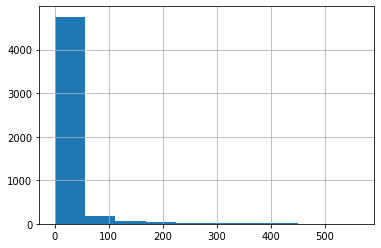

In [195]:
df.filteredRefs.apply(len).hist()

In [187]:
def filterRefs(row):
    filteredRefs = []
    for ref in row["Refs"]:
        if row["sims"][ref] > 0.94:
            filteredRefs.append(ref)
    return filteredRefs

df["filteredRefs"] = df.apply(filterRefs, axis = 1)

In [188]:
"""
Add references to songs in events
"""
df_events["filteredRefs"] = [[] for i in range(len(df_events))]
for i_song, refs in tqdm_notebook(df["filteredRefs"].iteritems()):
    for i_event in refs:
        df_events.iloc[i_event]["filteredRefs"].append(i_song)
        
df_events["filteredRefs"] = df_events["filteredRefs"].apply(set)

C:\Users\SimonRoquette\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [ ]:
print(df["filteredRefs"].apply(len).max())
print(df["filteredRefs"].apply(len).mean())

In [ ]:
df_events.Entities.apply(lambda l : [x[0] for x in l])

In [ ]:
df_events["Ents"] = df_events.Entities.apply(lambda l : [x[0] for x in l])
df_events["Ents_types"] = df_events.Entities.apply(lambda l : [x[1] for x in l])

In [ ]:
df["Ents"] = df.Entities.apply(lambda l : [x[0] for x in l])
df["Ents_types"] = df.Entities.apply(lambda l : [x[1] for x in l])

In [ ]:
df_events.filteredRefs.apply(len)

## Save to csv for Website

In [198]:
df_events["num_refs"] = df_events.filteredRefs.apply(len)
df["num_refs"] = df.filteredRefs.apply(len)

In [168]:
df_events.columns

Index(['Year', 'Month', 'Day', 'Content', 'Wikipedia', 'Summary', 'Refs',
       'vect', 'filteredRefs', 'num_refs', 'Entities', 'Entities_more'],
      dtype='object')

In [167]:
df.columns

Index(['Rank', 'Song', 'Artist', 'Year', 'Lyrics', 'Genre', 'Album', 'Refs',
       'word_count', 'vect', 'sims', 'filteredRefs', 'Lyrics_print',
       'Entities', 'Entities_more'],
      dtype='object')

In [207]:
df["Youtube"] = tmp_songs.Youtube

In [42]:
def entities_embedding(row, songs = False):
    col = "Lyrics_print" if songs else "Summary"
    
    color = "#ffffff" if songs else "#f28e61"
    text_color = "color : #ffffff;" if not songs else ""
    
    if len(row["Entities_more"]) == 0:
        return row[col]
    
    s = ""
    original = row[col]
    prev_end = 0
    for ent, ent_type, start, end in row["Entities_more"]:
        s += original[prev_end : start]
        embedded_entity = ("<mark class=\"entity\" style=\"background: %s;%s padding: 0.05em 0.05em; margin: 0 0.15em;"
        "line-height: 1; border-radius: 0.35em;\">%s"
        "<span style=\"font-size: 0.5em; font-weight: bold;%s line-height: 1; border-radius: 0.35em; text-transform: uppercase;"
        "vertical-align: middle; margin-left: 0.25rem; margin-bottom:0.25rem\">%s</span></mark>""") % (color, text_color, ent, text_color, ent_type)
        s += embedded_entity
        prev_end = end
    s+=original[prev_end :]
    
    return s

### Extra refs

In [80]:
print(df_events.filteredRefs.apply(len).mean())
print(df.filteredRefs.apply(len).mean())

68.5560538116592
14.935521688159437


In [91]:
from tqdm import tqdm_notebook

In [92]:
for i_event, event in tqdm_notebook(df_events.iterrows()):
    i = 0

C:\Users\SimonRoquette\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [94]:
for i_event, event in tqdm_notebook(df_events.iterrows()):
    for i_music, music in df.iterrows():
        trigger_values = [music.Song.lower(), music.Album.lower()] + music.Artist.lower().split("and")
        for value in trigger_values:
            if value in event.Content.lower() or value in event.Summary.lower():
                event.filteredRefs.add(i_music)
                music.filteredRefs.add(i_event)

C:\Users\SimonRoquette\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [95]:
print(df_events.filteredRefs.apply(len).mean())
print(df.filteredRefs.apply(len).mean())

278.2008968609866
60.608440797186404


In [37]:
df_events["Summary_embedded"] = df_events.apply(entities_embedding, axis = 1)

In [96]:
df_events.drop(columns = ["vect", "Refs", "Entities", "word_count", "text_vect"])\
.to_csv("datasets/events_refs_website.csv")

In [40]:
df["Lyrics_print_embedded"] = df.apply(entities_embedding, axis = 1)

In [97]:
df.drop(columns = ["vect", "sims", "Refs", "word_count", "Entities", "Lyrics"]).rename(columns = {"Lyrics_display": "Lyrics"})\
.to_csv("datasets/songs_refs_website.csv")

In [235]:
df.Entities_more.apply(len).mean()

8.18190699491989

In [236]:
df[df.Song.str.contains("Whatcha gonna")]

,Rank,Song,Artist,Year,Lyrics,Genre,Album,Refs,word_count,vect,sims,filteredRefs,Lyrics_print,Entities,Entities_more,num_refs,Youtube,Lyrics_print_embedded
1219,16,Whatcha gonna do,Pablo Cruise,1977,Whatcha gonna do When she says goodbye Whatcha...,Pop,A Place In The Sun,{},270,"[0.7500965595245361, -0.9582203030586243, -0.4...","[0.9548602001877042, 0.9568061277065438, 0.925...",[],Whatcha gonna do\r\nWhen she says goodbye\r\nW...,[],[],0,https://www.youtube.com/watch?v=NPWqe7l6JK8,Whatcha gonna do\r\nWhen she says goodbye\r\nW...


In [54]:
df[df.Song.str.contains("Every")]

,Rank,Song,Artist,Year,Lyrics,Genre,Album,Refs,word_count,vect,sims,filteredRefs,Lyrics_print,Entities,Entities_more,num_refs,Youtube,Lyrics_print_embedded
404,5,Everyday people,Sly The Family Stone,1969,Sometimes I'm right and I can be wrong My own ...,Funk,Stand,{},243,"[-0.6625109910964966, -0.9864662885665894, -0....","[0.9189457064123593, 0.9308117551613521, 0.918...",[],Sometimes I'm right and I can be wrong\r\nMy o...,[],[],0,https://www.youtube.com/watch?v=YUUhDoCx8zc,Sometimes I'm right and I can be wrong\r\nMy o...
472,73,Everybodys talkin,Harry Nilsson,1969,Everybody's talkin' at me I don't hear a word ...,Pop,Aerial Ballet,{},186,"[0.9065132141113281, -0.9525209665298462, -0.5...","[0.9402395806198696, 0.9533729585696741, 0.938...",[],Everybody's talkin' at me\r\nI don't hear a wo...,"[(Wohm, GPE)]","[(Wohm, GPE, 391, 395), (Wohm, GPE, 415, 419),...",0,https://www.youtube.com/watch?v=55xQu9eIPIA,Everybody's talkin' at me\r\nI don't hear a wo...
511,12,Everything is beautiful,Ray Stevens,1970,Jesus loves the little children All the little...,Pop,Everything Is Beautiful,"{1025, 2, 1027, 1028, 5, 518, 1029, 8, 1033, 5...",281,"[0.5493150353431702, -0.9113931655883789, -0.1...","[0.9132380353709844, 0.905950031930215, 0.8988...","[1042, 28, 62, 110, 117, 147, 156, 177, 203, 2...",Jesus loves the little children\r\nAll the lit...,"[(Jesus, PERSON), (Jesus, PERSON), (winter's d...","[(Jesus, PERSON, 0, 5), (Jesus, PERSON, 136, 1...",21,https://www.youtube.com/watch?v=0a45z_HG3WU,"<mark class=""entity"" style=""background: #fffff..."
732,29,Everybody plays the fool,The Main Ingredient,1972,"Okay , so you're heartbroken You sit around m...",R&B Soul,Bitter Sweet,"{1026, 515, 517, 1039, 17, 20, 22, 1046, 1051,...",288,"[0.6118214130401611, -0.9598145484924316, -0.1...","[0.8885130425318898, 0.8952057965525602, 0.855...","[633, 220, 836, 853, 860, 349, 359]","Okay, so you're heartbroken\r\nYou sit around ...","[(mopin, PERSON), (Love, WORK_OF_ART), (earth,...","[(mopin, PERSON, 44, 49), (Love, WORK_OF_ART, ...",7,https://www.youtube.com/watch?v=7i72cbo_qdg,"Okay, so you're heartbroken\r\nYou sit around ..."
755,52,Everything i own,Bread,1972,"You sheltered me from harm Kept me warm , kep...",Rock,Baby Im A Want You,"{513, 515, 1033, 140, 525, 653, 911, 17, 913, ...",227,"[0.7286788821220398, -0.9704616069793701, -0.6...","[0.9173026583267022, 0.9138904362785629, 0.888...","[17, 533, 285, 799, 570, 508]","You sheltered me from harm\r\nKept me warm, ke...","[(all the years, DATE), (one day, DATE)]","[(all the years, DATE, 141, 154), (one day, DA...",6,https://www.youtube.com/watch?v=2Fvb5woQ3ZI,"You sheltered me from harm\r\nKept me warm, ke..."
1361,57,Every time i turn around back in love again,Ltd,1978,"Every time I move , I lose When I look I'm in...",Funk,Something To Love,"{768, 769, 514, 770, 391, 139, 919, 154, 282, ...",647,"[0.9999950528144836, -0.8287438750267029, 0.98...","[0.9066736703358013, 0.9254408641057726, 0.912...","[514, 919, 154, 295, 313, 587, 204, 86, 475, 7...","Every time I move, I lose\r\nWhen I look I'm i...","[(Jones, PERSON)]","[(Jones, PERSON, 1449, 1454)]",13,https://www.youtube.com/watch?v=K3H-efs9wL4,"Every time I move, I lose\r\nWhen I look I'm i..."
1377,73,Every kinda people,Robert Palmer,1978,Said the fight to make ends meet Keeps a man u...,Rock,Double Fun,{},243,"[-0.8171799778938293, -0.9947508573532104, -0....","[0.8768804541475473, 0.883974081720005, 0.8572...",[],Said the fight to make ends meet\r\nKeeps a ma...,[],[],0,https://www.youtube.com/watch?v=R686uRAzwIk,Said the fight to make ends meet\r\nKeeps a ma...
1459,55,Every 1s a winner,Hot Chocolate,1979,"Never could believe the things you do to me , ...",Rock,Every 1S A Winner Single Version,"{417, 774, 903, 871, 487, 683, 428, 812, 339, ...",277,"[-0.14156875014305115, -0.9837441444396973, -0...","[0.8837662543673136, 0.8765139598094462, 0.854...",[774],"Never could believe the things you do to me,\r...","[(the day, DATE)]","[(th

In [53]:
df_events[df_events.Content.str.contains("Sri Lanka score")].Wikipedia[479]

'https://en.wikipedia.org/wiki/List_of_Test_cricket_records'

In [107]:
df_events.drop(columns = ["vect", "Refs", "Entities", "word_count", "text_vect"])\
.to_csv("datasets/events_refs_website.csv")

In [100]:
df.num_refs = df.filteredRefs.apply(len)

In [105]:
df.drop(columns = ["vect", "sims", "Refs", "word_count", "Entities", "Lyrics"]).rename(columns = {"Lyrics_display": "Lyrics"})\
.to_csv("datasets/songs_refs_website.csv")

In [106]:
df_events[["Year", "Month", "Day", "Content", "Wikipedia", "Summary", "Entities", "filteredRefs", "num_refs"]]\
.to_json("events_refs_final.json")

In [101]:
df_events.num_refs = df_events.filteredRefs.apply(len)

In [102]:
df_events[["Year", "Month", "Day", "Content", "Wikipedia", "Summary", "Entities", "filteredRefs", "num_refs"]]\
.a
.to_csv("events_refs_final.csv")

SyntaxError: invalid syntax (<ipython-input-102-5ca97d8ba853>, line 3)

In [ ]:
tmp = pd.read_csv("events_refs_final.csv", index_col = 0)
tmp.head()

In [ ]:
df_events.head()

In [ ]:
df.head()

In [ ]:
df["num_refs"] = df["filteredRefs"].apply(len)

In [ ]:
df_events["num_refs"] = df_events["filteredRefs"].apply(len)

In [ ]:
df.head(2)

In [ ]:
df[df["filteredRefs"].apply(len) == 0].Year.hist()

In [ ]:
print(df_events["filteredRefs"].apply(len).max())
print(df_events["filteredRefs"].apply(len).mean())
print(df_events["Refs"].apply(len).max())
print(df_events["Refs"].apply(len).mean())

In [ ]:
print(df["filteredRefs"].apply(len).max())
print(df["filteredRefs"].apply(len).mean())
print(df["Refs"].apply(len).max())
print(df["Refs"].apply(len).mean())

In [ ]:
with open("events_vects.pickle", "rb") as f:
    tmp = pickle.load(f)

In [ ]:
with open("events_vects.pickle", "wb") as f:
    pickle.dump(events_vectorized, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
df[df.Artist.str.contains("dire straits")]

In [ ]:
events_vectorized = []
batch_size = 8
with torch.no_grad():
    for i in tqdm_notebook(range(0, len(df_events), batch_size)):
        batch = events_tokenized[i: min(i + batch_size, len(df_events))].to(device)
        events_vectorized.append(model(batch))
        del batch
        
events_vectorized = [x[1] for x in events_vectorized]

In [ ]:
events_vectors = []
for batch_event in events_vectorized:
    for event in batch_event:
        events_vectors.append(event.tolist())
        
df_events["vect"] = events_vectors

In [ ]:
df_events

In [ ]:
df_events.head()

In [ ]:
df_events.Refs.head(20)

In [ ]:
# df["text_vect"] = df.Summary.fillna(df_events.Content)
# df["word_count"] = df["Lyrics"].apply(lambda x : len(x.split(" ")))
# df["text_vect"] = np.where(df["word_count"] > 400, df_events.Content, df_events["text_vect"])
# df["word_count"] = df_events["text_vect"].apply(lambda x : len(x.split(" ")))

In [ ]:
tmp = [ for sent in df_events["text_vect"]]
x = torch.tensor(tmp)

## Export tsv

In [ ]:
len(model.docvecs.vectors_docs)

In [ ]:
pd.DataFrame(model.docvecs.vectors_docs).to_csv("vec.tsv", index = False, sep = "\t", header=False)

In [ ]:
df.to_csv("data.tsv", sep = "\t", index = False)